# Identifying Credit Card Fraud

In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
pd.options.display.max_columns = 30
import lib.machine_learning as ml
import lib.data_preproc as pp
import lib.plots as plots

In [2]:
fraud_df = pd.read_csv('./data/Fraud_Data.csv')
ip_df = pd.read_csv('./data/IpAddress_to_Country.csv')
fraud_df = fraud_df.dropna()

In [3]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 13.8+ MB


In [4]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
fraud_df[fraud_df['class'] == 1].head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
24,171711,2015-01-11 01:51:15,2015-01-11 01:51:16,52,YPLQGKBAAULUV,Direct,IE,F,35,1.120619e+09,1
25,59780,2015-01-04 22:32:33,2015-01-16 01:13:43,31,WUMOBGUCBOXPO,SEO,FireFox,M,36,1.752167e+09,1
29,151705,2015-01-07 03:44:53,2015-01-07 03:44:54,48,URHCRIXOMLJMH,SEO,Chrome,F,27,2.836025e+09,1
59,345865,2015-02-01 05:59:23,2015-02-20 08:09:10,36,FKQPZUELCRKBL,SEO,IE,M,30,2.740590e+09,1


In [6]:
ip_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
uniques, indices, counts = np.unique(fraud_df['ip_address'], return_inverse=True, return_counts=True)
ip_uses = [None] * fraud_df.shape[0]
for i, index in enumerate(indices):
    ip_uses[i] = counts[index]
fraud_df.insert(9, 'ip_uses', ip_uses)

In [8]:
countries = [None] * fraud_df.shape[0]
for i, ip in enumerate(fraud_df['ip_address']):
    if i % 10000 == 0: print(i)
    idx = ip_df['lower_bound_ip_address'].searchsorted(ip) - 1
    country = ip_df['country'][idx].values[0]
    countries[i] = country

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [9]:
fraud_df.insert(fraud_df.shape[1] - 1, 'country', pd.Series(countries))
fraud_df = fraud_df.drop('ip_address', axis=1)
fraud_df.head(1)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_uses,country,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,1,Japan,0


In [10]:
from datetime import datetime

def time_difference(signup, purchase):
    time_difference = create_datetime(purchase) - create_datetime(signup)
    return time_difference.seconds

def create_datetime(time):
    year = int(time[:4])
    month = int(time[5:7])
    date = int(time[8:10])
    hour = int(time[11:13])
    minutes = int(time[14:16])
    seconds = int(time[17:19])
    return datetime(year, month, date, hour=hour, minute=minutes, second=seconds)

In [11]:
elapsed_time = [None] * fraud_df.shape[0]
for i, row in enumerate(fraud_df.itertuples()):
    elapsed_time[i] = time_difference(row.signup_time, row.purchase_time)

In [12]:
fraud_df.insert(3, 'elapsed_time', pd.Series(elapsed_time))
fraud_df.head(1)

,user_id,signup_time,purchase_time,elapsed_time,purchase_value,device_id,source,browser,sex,age,ip_uses,country,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,13882,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,1,Japan,0


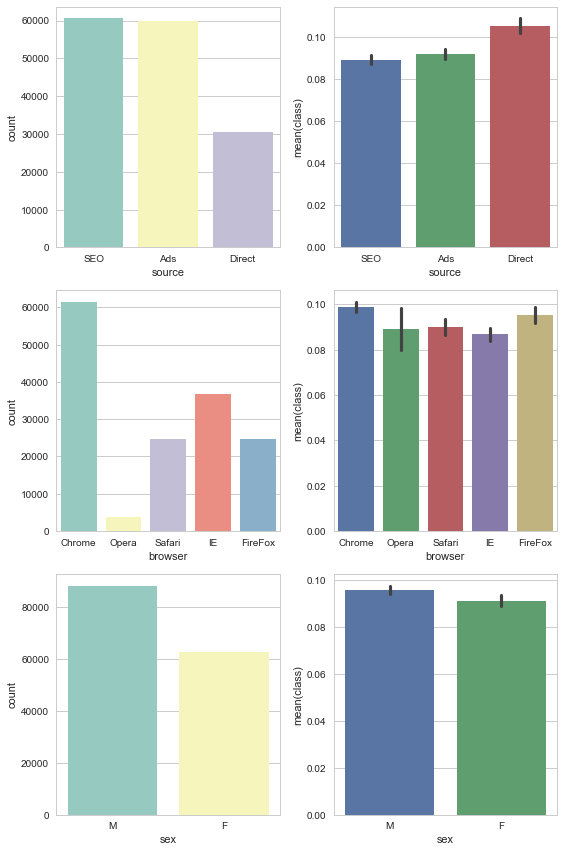

In [13]:
factors = ['source', 'browser', 'sex']
plots.factor_plot(fraud_df, factors, 'class')

In [14]:
uniques, indices, counts = np.unique(fraud_df['device_id'], return_inverse=True, return_counts=True)
device_uses = [None] * fraud_df.shape[0]
for i, index in enumerate(indices):
    device_uses[i] = counts[index]
fraud_df.insert(6, 'device_uses', pd.Series(device_uses))
fraud_df.head(1)

,user_id,signup_time,purchase_time,elapsed_time,purchase_value,device_id,device_uses,source,browser,sex,age,ip_uses,country,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,13882,34,QVPSPJUOCKZAR,1,SEO,Chrome,M,39,1,Japan,0


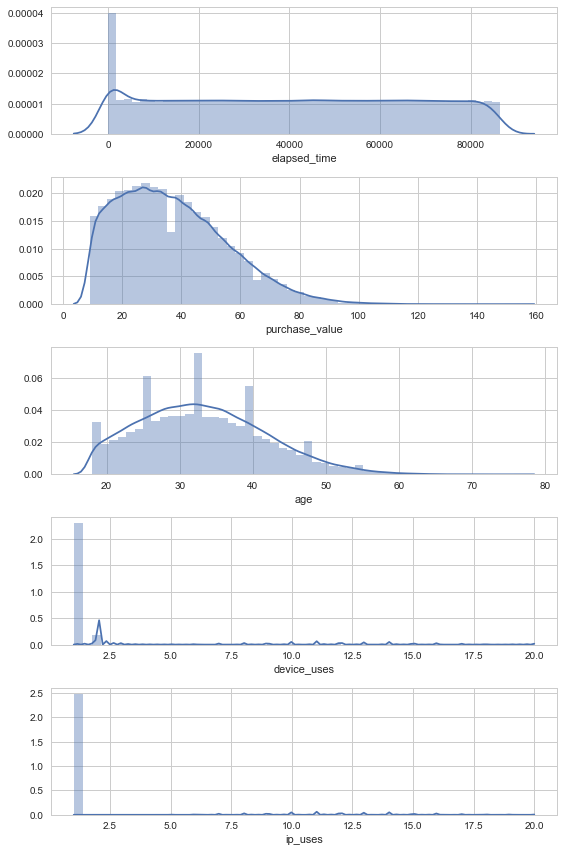

In [15]:
plots.continuous_plots(fraud_df, ['elapsed_time', 'purchase_value', 'age', 'device_uses', 'ip_uses'])

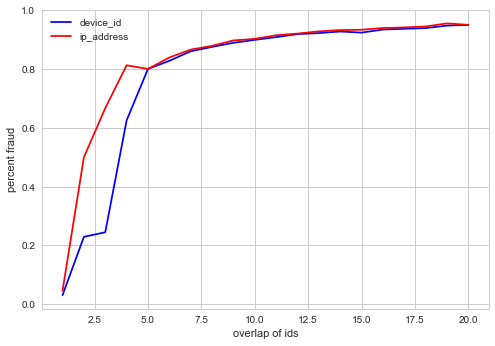

In [16]:
d_bins = np.arange(1, max(fraud_df['device_uses']) + 1)
i_bins = np.arange(1, max(fraud_df['ip_uses']) + 1)
d_counts = []
i_counts = []

for x in d_bins:
    df_slice = fraud_df[fraud_df['device_uses'] == x]
    d_counts.append(df_slice['class'].mean())
    
for x in i_bins:
    df_slice = fraud_df[fraud_df['ip_uses'] == x]
    i_counts.append(df_slice['class'].mean())
    
plt.plot(d_bins, d_counts, color='b', label='device_id')
plt.plot(i_bins, i_counts, color='r', label='ip_address')
plt.legend()
plt.xlabel('overlap of ids')
plt.ylabel('percent fraud')
plt.show()

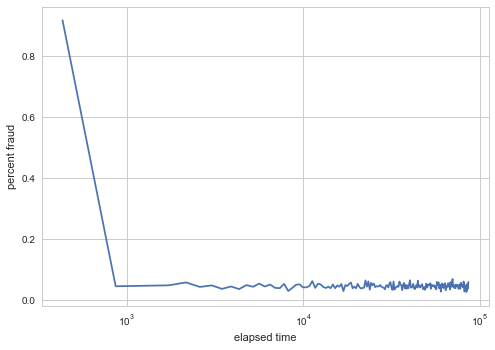

In [17]:
bins, step = np.linspace(0, max(fraud_df['elapsed_time']), 200, retstep=True)
bins = bins[1:]
values = [fraud_df[(fraud_df['elapsed_time'] >= edge - step) & 
                      (fraud_df['elapsed_time'] < edge)]['class'].mean() for edge in bins]
plt.plot(bins, values)
plt.xscale('log')
plt.xlabel('elapsed time')
plt.ylabel('percent fraud')
plt.show()

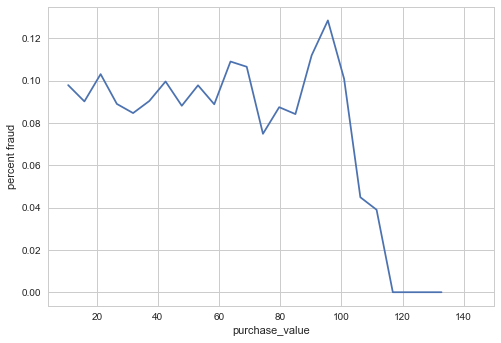

In [18]:
bins, step = np.linspace(0, max(fraud_df['purchase_value']), 30, retstep=True)
bins = bins[1:]
values = [fraud_df[(fraud_df['purchase_value'] >= edge - step) & 
                      (fraud_df['purchase_value'] < edge)]['class'].mean() for edge in bins]
plt.plot(bins, values)
plt.xlabel('purchase_value')
plt.ylabel('percent fraud')
plt.show()

In [19]:
import math
def is_not_nan(val):
    if type(val) == float:
        return not math.isnan(val)
    return True
v_isnan = np.vectorize(is_not_nan)
initial_length = fraud_df.shape[0]
fraud_df = fraud_df[v_isnan(fraud_df['country'])]
'Removing NaN values reduced dataframe by {0} rows'.format(initial_length - fraud_df.shape[0])

'Removing NaN values reduced dataframe by 634 rows'

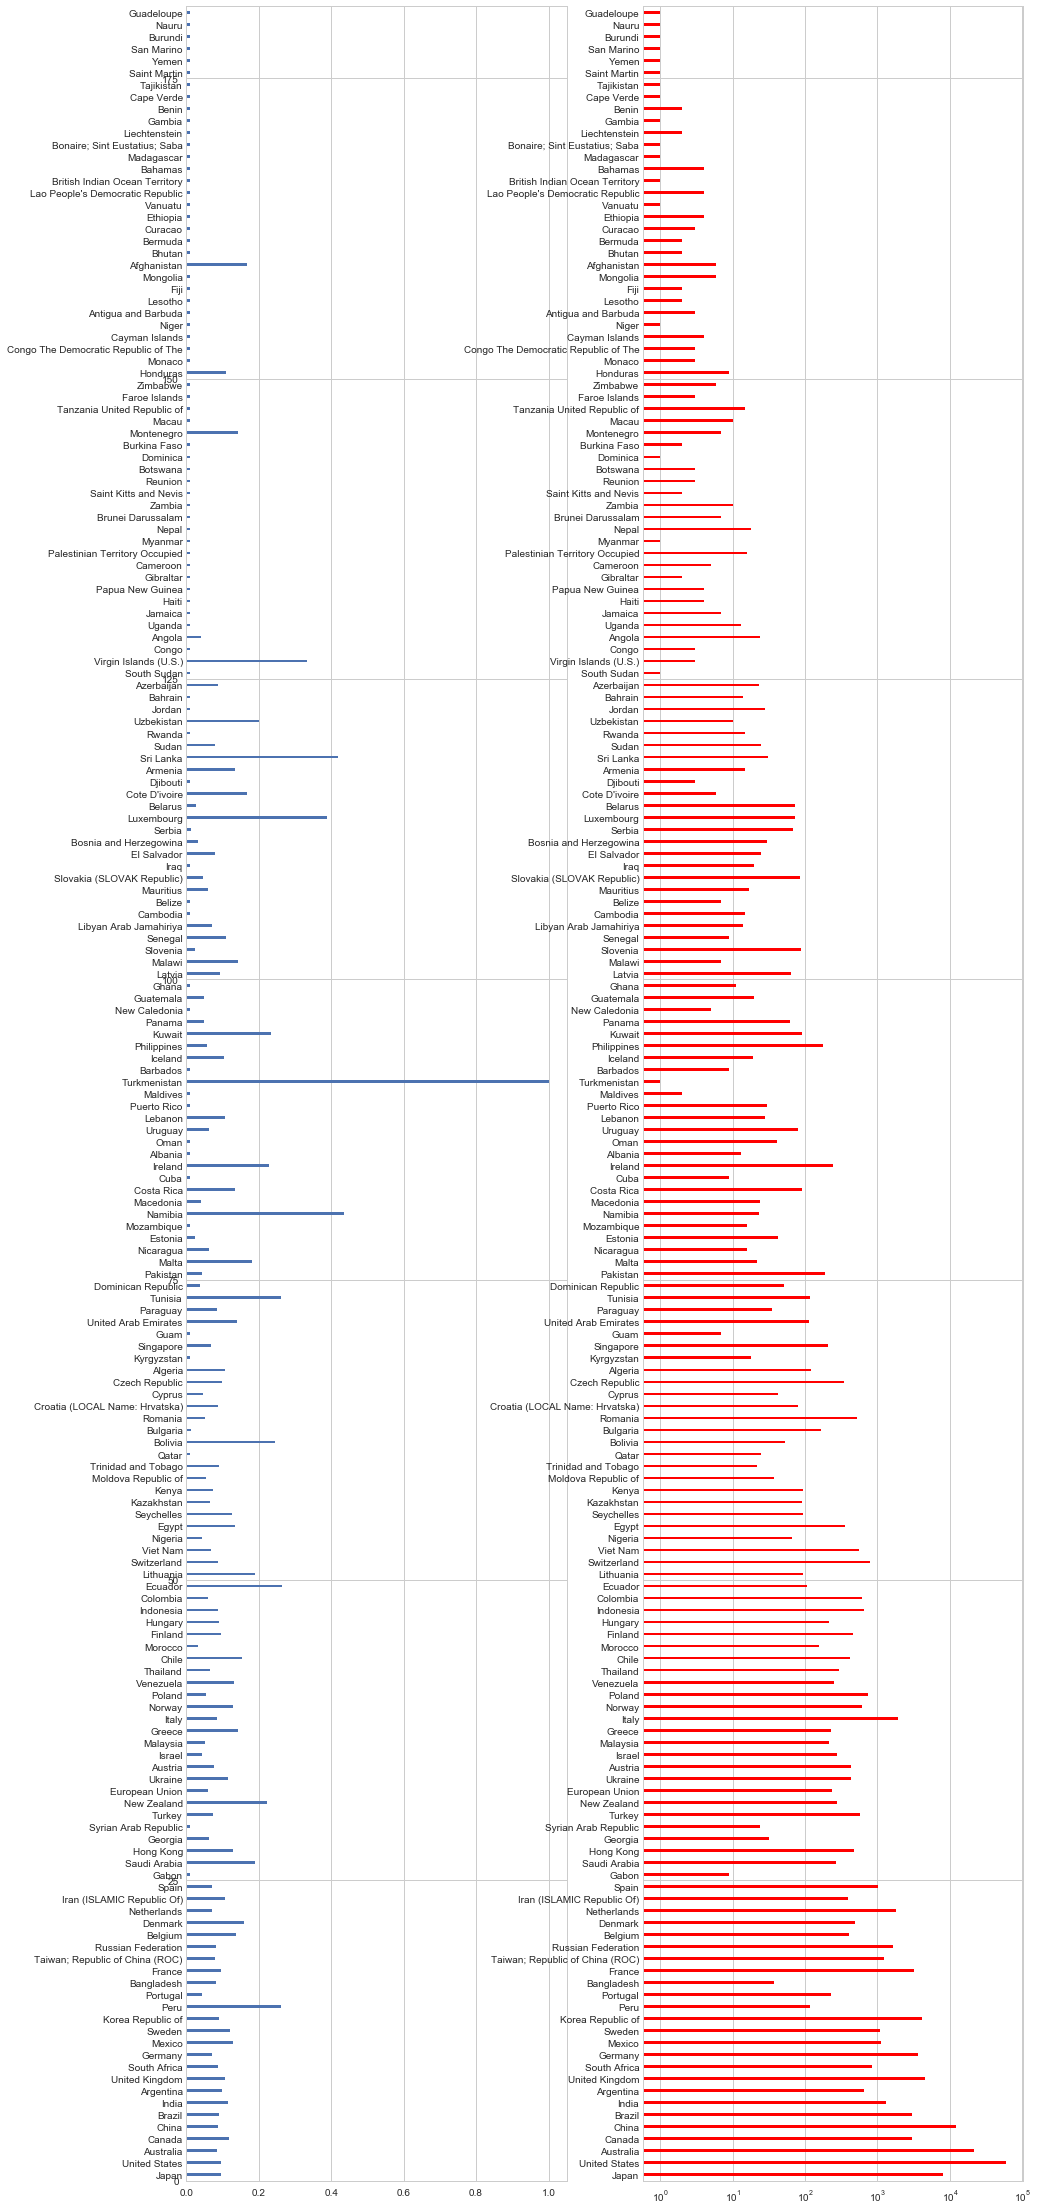

In [20]:
countries = fraud_df['country'].unique()

pos = np.arange(len(countries)) + 0.5
height = 40 / len(countries)

averages = []
counts = []
for country in countries:
    avg = fraud_df[fraud_df['country'] == country]['class'].mean()
    count = fraud_df[fraud_df['country'] == country].shape[0]
    if avg == 0: avg = 0.01
    averages.append(avg)
    counts.append(count)
    
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 40))
# first plot

ax1.barh(pos, averages, height=height)
ax1.set_yticks(pos, minor=True)
ax1.set_yticklabels(countries, minor=True)
ax1.set_ylim(min(pos) - 0.5, max(pos) + 0.5)

# second plot
ax2.barh(pos, counts, height=height, color='r')
ax2.set_ylim(min(pos) - 0.5, max(pos) + 0.5)
ax2.set_xscale('log')

plt.show()

In [21]:
# make a pie chart of where most fraud people are
import pycountry as pyc
codes = []
for country in countries:
    try:
        code = pyc.countries.get(name=country).alpha_2
    except KeyError:
        code = np.nan
    codes.append(code)
    
indices = []
for i, (country, code) in enumerate(zip(countries, codes)):
    if type(code) is not str:
        indices.append(i)
        print('{0}: {1}'.format(i, country))

13: Korea Republic of
18: Taiwan; Republic of China (ROC)
23: Iran (ISLAMIC Republic Of)
32: European Union
41: Venezuela
58: Moldova Republic of
61: Bolivia
64: Croatia (LOCAL Name: Hrvatska)
66: Czech Republic
81: Macedonia
104: Libyan Arab Jamahiriya
108: Slovakia (SLOVAK Republic)
111: Bosnia and Herzegowina
115: Cote D'ivoire
126: Virgin Islands (U.S.)
135: Palestinian Territory Occupied
141: Reunion
146: Macau
147: Tanzania United Republic of
152: Congo The Democratic Republic of The
162: Curacao
169: Bonaire; Sint Eustatius; Saba
173: Cape Verde
175: Saint Martin


In [22]:
import csv
reader = csv.reader(open('./data/country_continent.csv', 'r'))
iso = {}
for k, v in reader:
   iso[k] = v

In [23]:
continents = np.array([None] * len(countries))

for i, code in enumerate(codes):
    try:
        continents[i] = iso[code]
    except KeyError:
        pass
continent_missing_subset = ['AS', 'AS', 'AS', 'EU', 'SA', 'EU', 'SA', 'EU', 'EU', 'EU', 'AF', 'EU',
                           'EU', 'AF', 'NA', 'AS', 'AF', 'AS', 'AF', 'AF', 'SA', 'SA', 'AF', 'NA']
continents[indices] = continent_missing_subset
continents

array(['AS', 'NA', 'OC', 'NA', 'AS', 'SA', 'AS', 'SA', 'EU', 'AF', 'EU',
       'NA', 'EU', 'AS', 'SA', 'EU', 'AS', 'EU', 'AS', 'EU', 'EU', 'EU',
       'EU', 'AS', 'EU', 'AF', 'AS', 'AS', 'AS', 'AS', 'EU', 'OC', 'EU',
       'EU', 'EU', 'AS', 'AS', 'EU', 'EU', 'EU', 'EU', 'SA', 'AS', 'SA',
       'AF', 'EU', 'EU', 'AS', 'SA', 'SA', 'EU', 'EU', 'AS', 'AF', 'AF',
       'AF', 'AS', 'AF', 'EU', 'NA', 'AS', 'SA', 'EU', 'EU', 'EU', 'AS',
       'EU', 'AF', 'AS', 'AS', 'OC', 'AS', 'SA', 'AF', 'NA', 'AS', 'EU',
       'NA', 'EU', 'AF', 'AF', 'EU', 'NA', 'NA', 'EU', 'EU', 'AS', 'SA',
       'AS', 'NA', 'AS', 'AS', 'NA', 'EU', 'AS', 'AS', 'NA', 'OC', 'NA',
       'AF', 'EU', 'AF', 'EU', 'AF', 'AF', 'AS', 'NA', 'AF', 'EU', 'AS',
       'NA', 'EU', 'EU', 'EU', 'EU', 'AF', 'AF', 'AS', 'AS', 'AF', 'AF',
       'AS', 'AS', 'AS', 'AS', None, 'NA', 'AF', 'AF', 'AF', 'NA', 'NA',
       'OC', 'EU', 'AF', 'AS', 'AS', 'AS', 'AS', 'AF', 'NA', 'AF', 'AF',
       'NA', 'AF', 'EU', 'AS', 'AF', 'EU', 'AF', 'N

In [24]:
for i, (country, code) in enumerate(zip(countries, continents)):
    if code is None:
        print(i, country)

125 South Sudan


The country code to continent table mapping must not have been updated for South Sudan, so we'll do that ourselves.

In [25]:
continents[125] = 'AF'

In [26]:
# now to create the continent column
continent_column = np.array([None] * fraud_df.shape[0])
for i, country in enumerate(fraud_df['country']):
    idx = np.where(countries == country)[0]
    if i > 150478: print(i, continents[idx][0])
    continent_column[i] = continents[idx][0]

In [27]:
fraud_df.insert(12, 'continent', continent_column)
fraud_df.head(1)

,user_id,signup_time,purchase_time,elapsed_time,purchase_value,device_id,device_uses,source,browser,sex,age,ip_uses,continent,country,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,13882,34,QVPSPJUOCKZAR,1,SEO,Chrome,M,39,1,AS,Japan,0


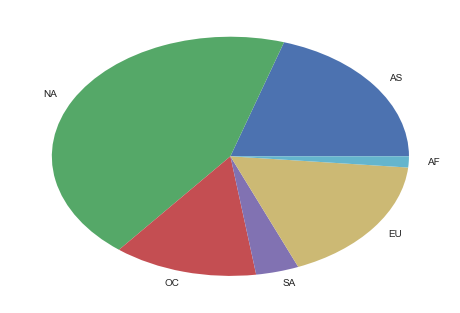

In [28]:
# make the pie chart
continents = fraud_df['continent'].unique()
counts = [sum(fraud_df[fraud_df['continent'] == continent]['class']) for continent in continents]
plt.pie(counts, labels=continents)
plt.show()

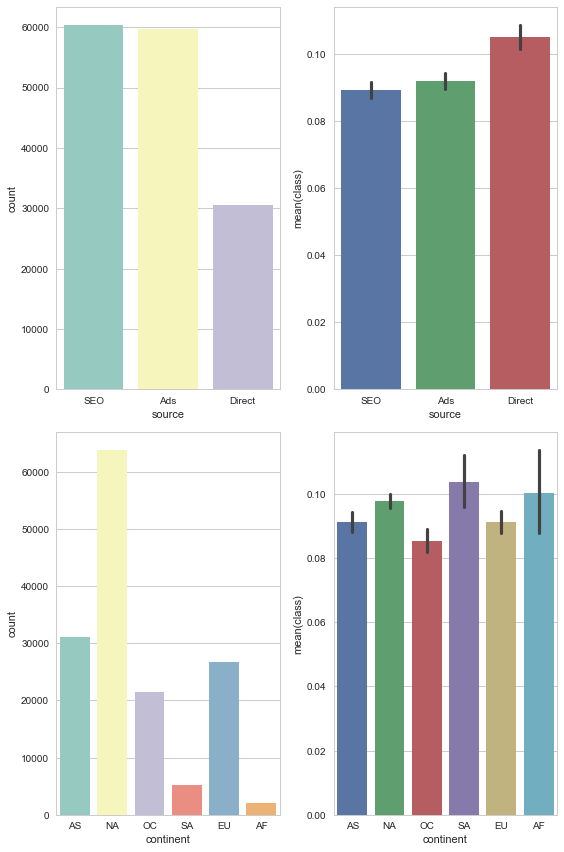

In [29]:
plots.factor_plot(fraud_df, ['source','continent'], 'class')

In [30]:
fraud_df.head()

,user_id,signup_time,purchase_time,elapsed_time,purchase_value,device_id,device_uses,source,browser,sex,age,ip_uses,continent,country,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,13882,34,QVPSPJUOCKZAR,1,SEO,Chrome,M,39,1,AS,Japan,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,17944,16,EOGFQPIZPYXFZ,1,Ads,Chrome,F,53,1,NA,United States,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,1,15,YSSKYOSJHPPLJ,12,SEO,Opera,M,53,12,NA,United States,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,60085,44,ATGTXKYKUDUQN,1,SEO,Safari,M,41,1,OC,Australia,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,41461,39,NAUITBZFJKHWW,1,Ads,Safari,M,45,1,NA,United States,0


In [31]:
train_data = fraud_df[
    ['elapsed_time', 'purchase_value', 'device_uses', 'source', 'browser', 'sex', 'age', 
     'ip_uses', 'continent', 'class']
]

train_data = pp.stratified_sampling(train_data, 'class', [0.3, 0.7], 0.1)
print('Now {0} samples'.format(train_data.shape[0])) 

categorical = ['continent', 'source', 'browser', 'sex']
for feature in categorical:
    train_data = pp.dummy_variable(train_data, feature)
train_data.head()

Class Imbalance Detected!
New Class Distributions
1:  0.7000006645533869
0:  0.2999993354466131
Now 150477 samples
All Variables are OK for continent column
All Variables are OK for source column
All Variables are OK for browser column
All Variables are OK for sex column


,elapsed_time,purchase_value,device_uses,age,ip_uses,class,NA,AS,AF,EU,OC,SA,SEO,Ads,Direct,IE,FireFox,Chrome,Safari,Opera,F,M
66994,45399,39,1,38,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
74970,37289,10,1,21,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0
62221,35289,56,1,33,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0
11275,40384,39,1,44,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0
147836,8440,38,1,30,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1


In [32]:
# scale the data
from sklearn.preprocessing import scale

scaled_names = ['elapsed_time', 'purchase_value', 'device_uses', 'age', 'ip_uses']
non_scaled_names = [name for name in train_data.columns if name not in scaled_names]
non_scaled_names.remove('class')

scaled_data = scale(train_data[scaled_names].values.astype('float64'))
non_scaled_data = train_data[non_scaled_names].values

y = train_data['class'].values
X = np.hstack((scaled_data, non_scaled_data))

In [33]:
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifier, LogisticRegression, SGDClassifier

models = [
    PassiveAggressiveClassifier(),
    LogisticRegression(),
    RidgeClassifier(),
    SGDClassifier()
]

model_names = [
    'Passive Aggressive',
    'Logistic Regression',
    'Ridge',
    'SGD'
]

Starting Iteration:  0
Cross Validation Scores:  0.812239857516
Accuracy Score:  0.730802714036
AUC Score:  0.705248133496
F1 Score:  0.8
Kappa:  0.390412288688
Normalized confusion matrix


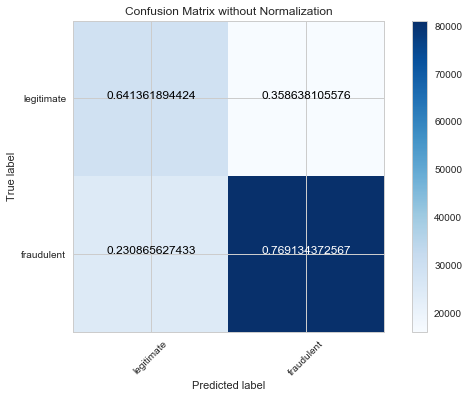

Starting Iteration:  1
Cross Validation Scores:  0.845272122562
Accuracy Score:  0.782398638995
AUC Score:  0.825026315649
F1 Score:  0.822140141228
Kappa:  0.556479603408
Normalized confusion matrix


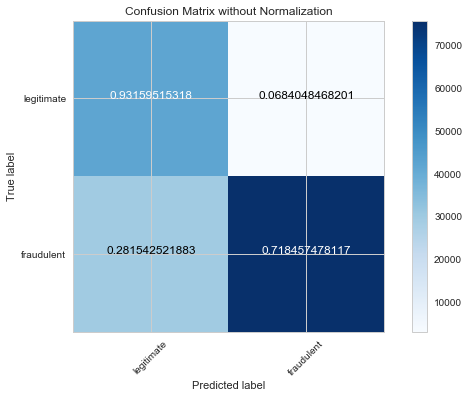

Starting Iteration:  2
Cross Validation Scores:  0.842713197466
Accuracy Score:  0.757830100281
AUC Score:  0.726363516208
F1 Score:  0.823131992137
Kappa:  0.439830002114
Normalized confusion matrix


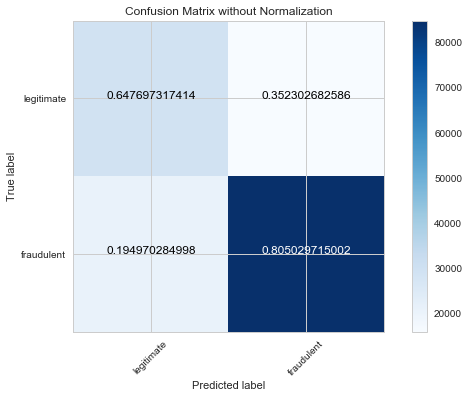

Starting Iteration:  3
Cross Validation Scores:  0.841223891955
Accuracy Score:  0.775567030177
AUC Score:  0.799133958094
F1 Score:  0.821982794973
Kappa:  0.528209948339
Normalized confusion matrix


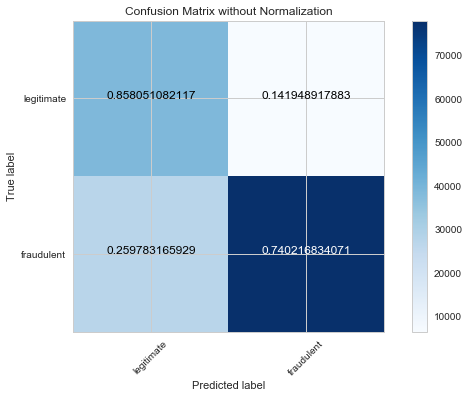

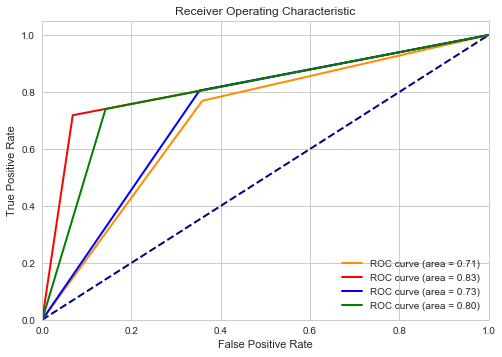

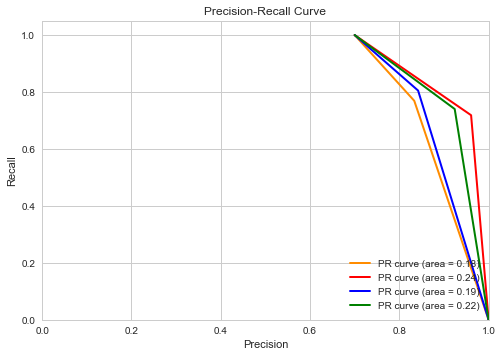

In [34]:
class_names = ['legitimate', 'fraudulent']
ml.cross_val_method(models, X, y, class_names)

Starting Iteration:  0
Cross Validation Scores:  0.830096592554
Accuracy Score:  0.738099510224
AUC Score:  0.652333589533
F1 Score:  0.822482275254
Kappa:  0.328220066196
Normalized confusion matrix


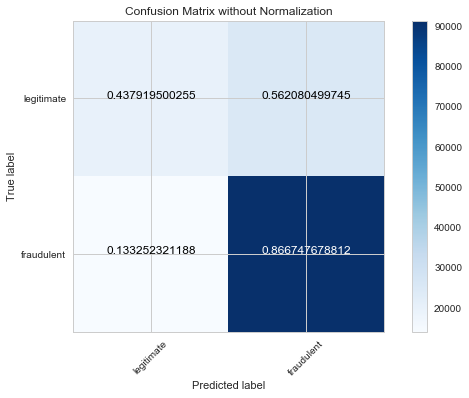

Starting Iteration:  1
Cross Validation Scores:  0.806950965239
Accuracy Score:  0.733347953508
AUC Score:  0.700566165106
F1 Score:  0.804246330076
Kappa:  0.387186283406
Normalized confusion matrix


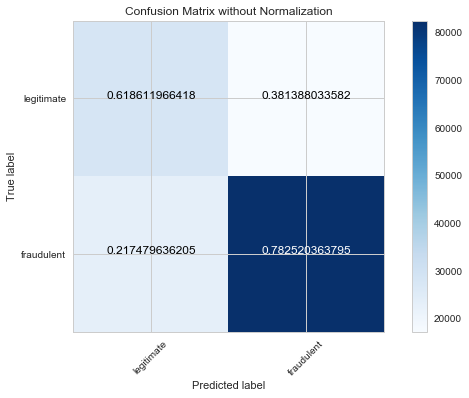

Starting Iteration:  2
Cross Validation Scores:  0.815312754373
Accuracy Score:  0.738597925264
AUC Score:  0.74008826497
F1 Score:  0.797725017098
Kappa:  0.435509298321
Normalized confusion matrix


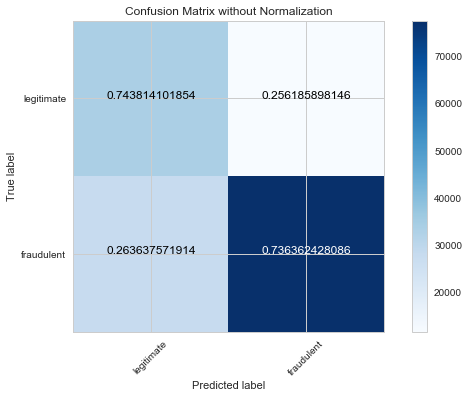

Starting Iteration:  3
Cross Validation Scores:  0.813073677302
Accuracy Score:  0.730337526665
AUC Score:  0.678150055509
F1 Score:  0.807621558067
Kappa:  0.356887393606
Normalized confusion matrix


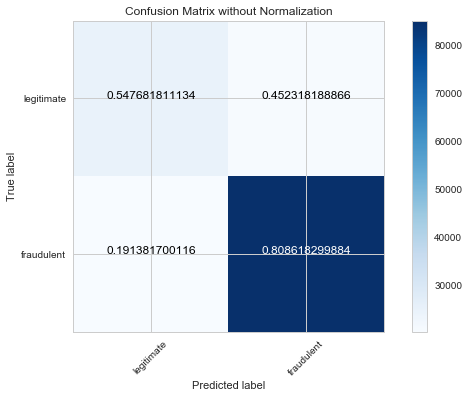

Starting Iteration:  4
Cross Validation Scores:  0.810104323143
Accuracy Score:  0.733793204277
AUC Score:  0.740143663679
F1 Score:  0.792055565361
Kappa:  0.431093585593
Normalized confusion matrix


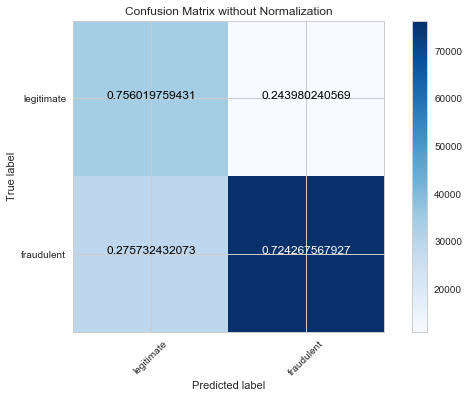

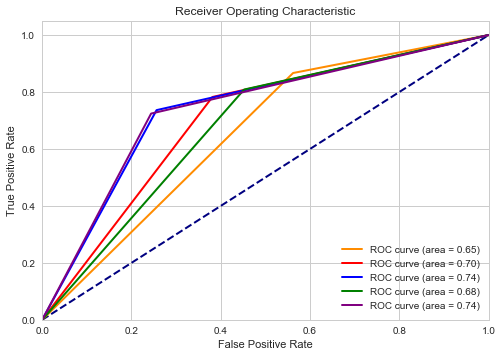

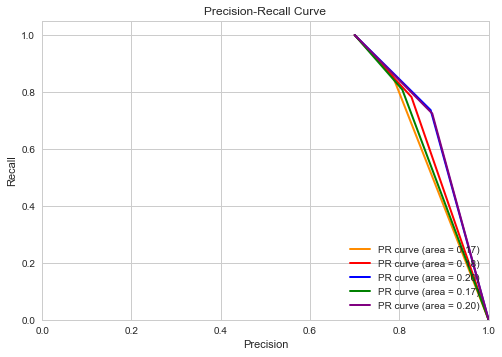

In [35]:
# use passive aggressive
models = [
    PassiveAggressiveClassifier(C=0.1, n_iter=30),
    PassiveAggressiveClassifier(C=0.5, n_iter=30),
    PassiveAggressiveClassifier(C=1, n_iter=30),
    PassiveAggressiveClassifier(C=5, n_iter=30),
    PassiveAggressiveClassifier(C=10, n_iter=30)
]

ml.cross_val_method(models, X, y, class_names)

In [38]:
# the first set of hyperparameters yielded us the highest F1 score and 
# highest true positive rate, so we'll go with that
from sklearn.metrics import f1_score
pa = models[0]
pa.fit(X, y)
pred = pa.predict(X)
f1_score(pred, y)

0.82434562978789305

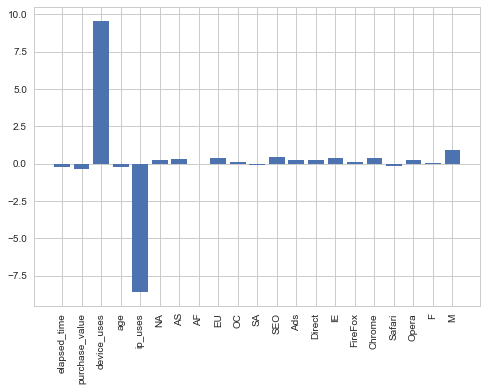

In [40]:
coef = pa.coef_[0]
coef_names = [*scaled_names, *non_scaled_names]

xaxis = np.arange(len(coef))
plt.bar(xaxis, coef)
plt.xticks(xaxis, coef_names, rotation=90)
plt.show()